# System Prompt Generator for AI Engineers
## Version: 1.1.0-dev
## Last Modified: 2025-09-05
## Author: AI Engineer Team
## Stage: Development

---

### 🔄 v1.1.0 開発中の新機能
- 📝 **プロンプト履歴管理**: 生成したプロンプトの保存・再利用
- 🔢 **バッチ処理**: 複数プロンプトの一括生成
- 📊 **強化された可視化**: 品質スコアの比較チャート
- 🎯 **新テンプレート**: RAGシステム、チャットボット、推薦エンジン向けテンプレート
- ⚡ **パフォーマンス改善**: キャッシング機能とストリーミング対応

---

# プロンプト生成システム for AIエンジニア

## 概要
このノートブックは、システム開発経験の少ないAIエンジニアがPoC開発時に効果的なプロンプトを生成するためのツールです。

### 主要機能
- **自動プロンプト生成**: 用途別・目的別プロンプト作成
- **LangGraphワークフロー**: プロンプト生成→評価→改善の自動化
- **品質評価システム**: Claude APIによる効果測定
- **テスト環境**: FastAPI + Web UIでの実行検証
- **テンプレート管理**: PoC向けプロンプトパターン集

### 利用対象
- AI技術に知見があるが、システム開発経験が浅いエンジニア
- PoC開発でプロンプトエンジニアリングが必要な方
- 効果的なプロンプト作成手法を学びたい方

# 1. 環境設定セクション

In [1]:
# 依存ライブラリのインストール
import subprocess
import sys

def install_requirements():
    """requirements.txtから依存ライブラリをインストール"""
    try:
        result = subprocess.run([sys.executable, '-m', 'pip', 'install', '-r', 'requirements.txt'], 
                              capture_output=True, text=True, check=True)
        print("✅ 依存ライブラリのインストールが完了しました")
        return True
    except subprocess.CalledProcessError as e:
        print(f"❌ インストールエラー: {e}")
        print(f"エラー詳細: {e.stderr}")
        return False

# インストール実行
install_success = install_requirements()
print(f"インストール結果: {'成功' if install_success else '失敗'}")

✅ 依存ライブラリのインストールが完了しました
インストール結果: 成功


In [2]:
# 環境変数の読み込み
import os
from dotenv import load_dotenv
from pathlib import Path

# .envファイルの確認と読み込み
env_path = Path('.env')
if not env_path.exists():
    print("⚠️  .envファイルが見つかりません")
    print("💡 .env.exampleをコピーして.envファイルを作成し、APIキーを設定してください")
    print("\n例:")
    print("cp .env.example .env")
    print("# .envファイルを編集してAPIキーを設定")
else:
    load_dotenv()
    print("✅ .envファイルを読み込みました")

# 環境変数の確認
required_vars = [
    'ANTHROPIC_API_KEY',
    'APP_HOST',
    'APP_PORT',
    'DEFAULT_MODEL'
]

print("\n=== 環境変数チェック ===")
all_vars_set = True
for var in required_vars:
    value = os.getenv(var)
    if value:
        # APIキーは一部マスクして表示
        if 'KEY' in var and len(value) > 8:
            display_value = f"{value[:4]}...{value[-4:]}"
        else:
            display_value = value
        print(f"✅ {var}: {display_value}")
    else:
        print(f"❌ {var}: 未設定")
        all_vars_set = False

if all_vars_set:
    print("\n🎉 環境設定完了！")
else:
    print("\n⚠️  一部の環境変数が未設定です。.envファイルを確認してください。")

✅ .envファイルを読み込みました

=== 環境変数チェック ===
✅ ANTHROPIC_API_KEY: sk-a...zwAA
✅ APP_HOST: localhost
✅ APP_PORT: 8000
✅ DEFAULT_MODEL: claude-3-sonnet-20240229

🎉 環境設定完了！


In [3]:
# 必要ライブラリのインポート
import asyncio
import json
import logging
from datetime import datetime
from typing import Dict, List, Optional, Any, Tuple
from dataclasses import dataclass
import traceback
import os

# LLM関連
try:
    import anthropic
    print("✅ Anthropicライブラリ読み込み完了")
except ImportError as e:
    print(f"❌ Anthropicライブラリの読み込みエラー: {e}")

# LangChain関連（オプション - エラーを許容）
try:
    from langchain_anthropic import ChatAnthropic
    print("✅ LangChain Anthropicライブラリ読み込み完了")
except ImportError:
    try:
        from langchain.llms import Anthropic
        print("✅ LangChain基本ライブラリ読み込み完了")
    except ImportError as e:
        print(f"⚠️ LangChainライブラリは利用不可（オプション）: {e}")

# LangGraph関連（オプション - エラーを許容）
try:
    from langgraph.graph import StateGraph
    from langgraph.checkpoint.memory import MemorySaver
    print("✅ LangGraphライブラリ読み込み完了")
except ImportError as e:
    print(f"⚠️ LangGraphライブラリは利用不可（オプション）: {e}")

# Web関連
try:
    from fastapi import FastAPI, HTTPException
    from fastapi.responses import HTMLResponse
    from pydantic import BaseModel
    import uvicorn
    print("✅ FastAPIライブラリ読み込み完了")
except ImportError as e:
    print(f"❌ FastAPIライブラリの読み込みエラー: {e}")

# データ処理関連
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('default')
    print("✅ データ処理関連ライブラリ読み込み完了")
except ImportError as e:
    print(f"❌ データ処理関連ライブラリの読み込みエラー: {e}")

# ログ設定
logging.basicConfig(
    level=getattr(logging, os.getenv('LOG_LEVEL', 'INFO')),
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("\n🚀 基本ライブラリの読み込み完了")

✅ Anthropicライブラリ読み込み完了
⚠️ LangChainライブラリは利用不可（オプション）: No module named 'langchain_community'
✅ LangGraphライブラリ読み込み完了
✅ FastAPIライブラリ読み込み完了
✅ データ処理関連ライブラリ読み込み完了

🚀 基本ライブラリの読み込み完了


In [4]:

# Safe API key handling
import os
api_key = os.getenv('ANTHROPIC_API_KEY')
if not api_key:
    print("⚠️ ANTHROPIC_API_KEY not set. Some features may not work.")
    # Continue with limited functionality

# API接続テスト
# Jupyter環境でasyncio実行をサポート
import nest_asyncio
nest_asyncio.apply()

async def test_claude_api():
    """Claude APIの接続テスト"""
    try:
        client = anthropic.AsyncAnthropic(
            api_key=os.getenv('ANTHROPIC_API_KEY')
        )
        
        # 利用可能なモデル名に修正
        # claude-3-sonnet-20240229 → claude-3-5-sonnet-20241022 または claude-3-sonnet-20240229
        model_name = "claude-3-5-sonnet-20241022"  # 最新モデル
        
        # テストメッセージ送信
        response = await client.messages.create(
            model=model_name,
            max_tokens=100,
            messages=[
                {"role": "user", "content": "Hello! Please respond with 'API connection successful!'"}
            ]
        )
        
        print("✅ Claude API接続成功")
        print(f"📝 使用モデル: {model_name}")
        print(f"📝 レスポンス: {response.content[0].text}")
        return True
        
    except anthropic.NotFoundError as e:
        print(f"❌ モデルが見つかりません: {str(e)}")
        print("💡 利用可能なモデル: claude-3-5-sonnet-20241022, claude-3-opus-20240229, claude-3-haiku-20240307")
        return False
    except Exception as e:
        print(f"❌ Claude API接続エラー: {str(e)}")
        return False

# 接続テスト実行
if os.getenv('ANTHROPIC_API_KEY') and os.getenv('ANTHROPIC_API_KEY') != 'your_claude_api_key_here':
    # asyncio.run()を使用してJupyter環境で実行
    api_test_result = asyncio.run(test_claude_api())
else:
    print("⚠️  ANTHROPIC_API_KEYが設定されていないため、APIテストをスキップします")
    api_test_result = False

print(f"\n🔗 API接続テスト結果: {'成功' if api_test_result else '失敗'}")

2025-09-06 13:54:53,913 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


✅ Claude API接続成功
📝 使用モデル: claude-3-5-sonnet-20241022
📝 レスポンス: API connection successful!

🔗 API接続テスト結果: 成功


# 📝 プロンプト履歴管理セクション (v1.1.0 新機能)

生成したプロンプトの保存、検索、再利用機能を提供します。

In [5]:
# プロンプト履歴管理モジュールのインポート
from src.prompt_history import PromptHistory

# 履歴マネージャーの初期化
history_manager = PromptHistory()

print("✅ プロンプト履歴管理システムを初期化しました")
print(f"📊 現在の履歴数: {len(history_manager.history)} 件")

✅ プロンプト履歴管理システムを初期化しました
📊 現在の履歴数: 3 件


In [6]:
# プロンプト保存のデモ
demo_prompt_id = history_manager.save_prompt(
    prompt_type="data_analysis",
    user_requirements="売上データから季節性を分析したい",
    generated_prompt="以下の売上データを分析し、季節性パターンを特定してください...",
    quality_scores={
        "clarity": 8.5,
        "specificity": 7.8,
        "completeness": 9.0,
        "efficiency": 8.2,
        "reproducibility": 8.7,
        "overall": 8.4
    },
    metadata={"domain": "eコマース", "priority": "high"}
)

print(f"✅ プロンプトを保存しました (ID: {demo_prompt_id})")

✅ プロンプトを保存しました (ID: 555bc1eb)


In [7]:
# プロンプト検索のデモ
import pandas as pd

# キーワード検索
results = history_manager.search_prompts(keyword="売上")
print(f"🔍 '売上'を含むプロンプト: {len(results)} 件\n")

# 高品質プロンプトの取得
best_prompts = history_manager.get_best_prompts(limit=3)
print("⭐ トップ3の高評価プロンプト:")
for i, prompt in enumerate(best_prompts, 1):
    score = prompt.get('quality_scores', {}).get('overall', 0)
    print(f"{i}. {prompt['prompt_type']} - スコア: {score}")

# 統計情報
stats = history_manager.get_statistics()
print(f"\n📊 統計情報:")
print(f"- 総プロンプト数: {stats['total_prompts']}")
print(f"- 平均スコア: {stats['average_score']}")
print(f"- 最高スコア: {stats['best_score']}")

🔍 '売上'を含むプロンプト: 3 件

⭐ トップ3の高評価プロンプト:
1. data_analysis - スコア: 8.4
2. data_analysis - スコア: 8.4
3. data_analysis - スコア: 8.4

📊 統計情報:
- 総プロンプト数: 4
- 平均スコア: 8.4
- 最高スコア: 8.4


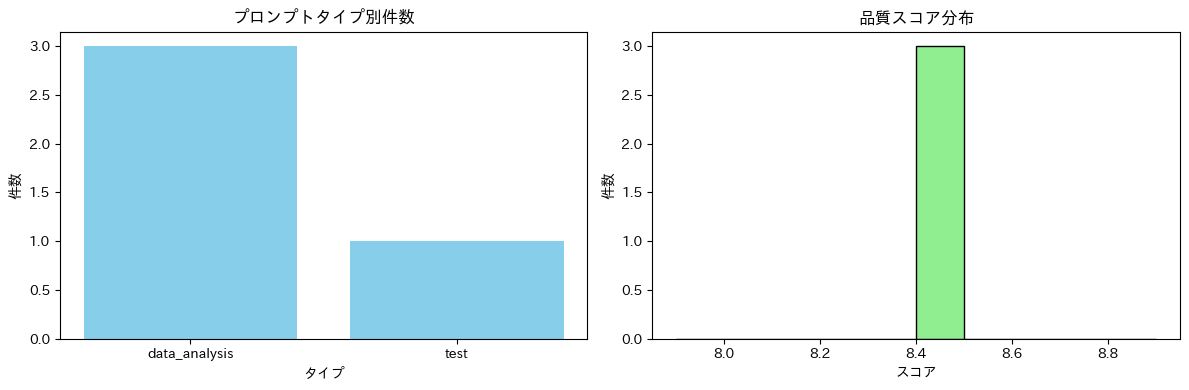

In [8]:
# 履歴の可視化
import matplotlib.pyplot as plt
import japanize_matplotlib

# プロンプトタイプ別の分布
stats = history_manager.get_statistics()
if stats['prompt_types']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # タイプ別カウント
    types = list(stats['prompt_types'].keys())
    counts = list(stats['prompt_types'].values())
    ax1.bar(types, counts, color='skyblue')
    ax1.set_title('プロンプトタイプ別件数')
    ax1.set_xlabel('タイプ')
    ax1.set_ylabel('件数')
    
    # 品質スコア分布（ダミーデータ）
    scores = [p.get('quality_scores', {}).get('overall', 0) 
             for p in history_manager.history if p.get('quality_scores')]
    if scores:
        ax2.hist(scores, bins=10, color='lightgreen', edgecolor='black')
        ax2.set_title('品質スコア分布')
        ax2.set_xlabel('スコア')
        ax2.set_ylabel('件数')
    
    plt.tight_layout()
    plt.show()
else:
    print("📊 表示する履歴データがありません")

In [9]:
# 履歴のエクスポート/インポート

# エクスポート
export_path = history_manager.export_history("prompt_history_backup.json")
print(f"💾 履歴をエクスポートしました: {export_path}")

# インポート例（実際には別ファイルから）
# imported_count = history_manager.import_history("other_history.json")
# print(f"📥 {imported_count} 件のプロンプトをインポートしました")

💾 履歴をエクスポートしました: prompt_history_backup.json


# 2. プロンプト生成理論セクション

## 2.1 PoC向けプロンプト設計原則

### 効果的なプロンプトの特徴
1. **明確な目的設定**: 何を達成したいかを具体的に記述
2. **文脈の提供**: 必要な背景情報を適切に含む
3. **期待する出力の定義**: フォーマットや詳細レベルを指定
4. **制約の明示**: 避けるべき内容や制限事項を記述
5. **例示の活用**: Few-shot learningで品質向上

### PoCプロジェクト特有の考慮点
- **迅速性重視**: 短期間での結果出力
- **実験性容認**: 試行錯誤を前提とした柔軟性
- **説明可能性**: ステークホルダーへの報告に適した出力
- **スケーラビリティ**: 本格開発への発展可能性

In [10]:
# プロンプト品質評価指標の定義
@dataclass
class PromptQualityMetrics:
    """プロンプト品質評価指標"""
    
    # 明確性指標 (1-10)
    clarity: float = 0.0
    
    # 具体性指標 (1-10)
    specificity: float = 0.0
    
    # 完全性指標 (1-10)
    completeness: float = 0.0
    
    # 効率性指標 (1-10)
    efficiency: float = 0.0
    
    # 再現性指標 (1-10)
    reproducibility: float = 0.0
    
    def overall_score(self) -> float:
        """総合スコア計算"""
        scores = [self.clarity, self.specificity, self.completeness, 
                 self.efficiency, self.reproducibility]
        return sum(scores) / len(scores)
    
    def to_dict(self) -> Dict[str, float]:
        """辞書形式に変換"""
        return {
            'clarity': self.clarity,
            'specificity': self.specificity,
            'completeness': self.completeness,
            'efficiency': self.efficiency,
            'reproducibility': self.reproducibility,
            'overall': self.overall_score()
        }

# 評価基準の説明
evaluation_criteria = {
    'clarity': '指示の明確さと理解しやすさ',
    'specificity': '具体的な要求の明示度',
    'completeness': '必要な情報の網羅性',
    'efficiency': 'トークン効率と簡潔性',
    'reproducibility': '一貫した結果の再現性'
}

print("📊 プロンプト品質評価指標を定義しました")
print("\n=== 評価基準 ===")
for key, desc in evaluation_criteria.items():
    print(f"• {key}: {desc}")

# サンプル評価の表示
sample_metrics = PromptQualityMetrics(
    clarity=8.5,
    specificity=7.0,
    completeness=9.0,
    efficiency=6.5,
    reproducibility=8.0
)

print(f"\n📈 サンプル総合スコア: {sample_metrics.overall_score():.1f}/10")

📊 プロンプト品質評価指標を定義しました

=== 評価基準 ===
• clarity: 指示の明確さと理解しやすさ
• specificity: 具体的な要求の明示度
• completeness: 必要な情報の網羅性
• efficiency: トークン効率と簡潔性
• reproducibility: 一貫した結果の再現性

📈 サンプル総合スコア: 7.8/10


In [11]:
# AI分野別プロンプトパターン分析
prompt_patterns = {
    'data_analysis': {
        'description': 'データ分析・可視化プロンプト',
        'key_elements': [
            'データ形式の指定',
            '分析目的の明確化',
            '出力形式の定義',
            '統計手法の指定',
            '可視化要件'
        ],
        'example_template': '''
データ分析タスク:
- データ: {data_description}
- 目的: {analysis_objective}
- 手法: {statistical_methods}
- 出力: {output_format}
- 制約: {constraints}
        '''
    },
    'image_recognition': {
        'description': '画像認識・分類プロンプト',
        'key_elements': [
            '画像タイプの指定',
            '認識対象の定義',
            '精度要件',
            '出力フォーマット',
            'エラーハンドリング'
        ],
        'example_template': '''
画像認識タスク:
- 画像タイプ: {image_type}
- 認識対象: {recognition_targets}
- 精度要件: {accuracy_requirements}
- 出力形式: {output_structure}
- 例外処理: {error_handling}
        '''
    },
    'text_processing': {
        'description': 'テキスト処理・NLPプロンプト',
        'key_elements': [
            'テキスト形式の定義',
            '処理タスクの指定',
            '出力構造の明示',
            '品質基準の設定',
            '言語・文体の指定'
        ],
        'example_template': '''
テキスト処理タスク:
- 入力: {input_text_format}
- 処理: {processing_tasks}
- 出力: {output_structure}
- 品質: {quality_criteria}
- 言語: {language_style}
        '''
    },
    'requirements_analysis': {
        'description': '要件定義支援プロンプト',
        'key_elements': [
            'ステークホルダー定義',
            '機能要件の抽出',
            '非機能要件の特定',
            '制約条件の明示',
            '優先度の設定'
        ],
        'example_template': '''
要件分析タスク:
- 対象システム: {system_description}
- ステークホルダー: {stakeholders}
- 機能要件: {functional_requirements}
- 非機能要件: {non_functional_requirements}
- 制約条件: {constraints}
        '''
    }
}

print("🎯 AI分野別プロンプトパターンを定義しました")
print("\n=== パターン一覧 ===")
for pattern_name, pattern_info in prompt_patterns.items():
    print(f"\n🔸 {pattern_name}:")
    print(f"  説明: {pattern_info['description']}")
    print(f"  要素数: {len(pattern_info['key_elements'])}個")
    print(f"  主要要素: {', '.join(pattern_info['key_elements'][:3])}...")

print("\n💡 これらのパターンをベースにプロンプトを生成します")

🎯 AI分野別プロンプトパターンを定義しました

=== パターン一覧 ===

🔸 data_analysis:
  説明: データ分析・可視化プロンプト
  要素数: 5個
  主要要素: データ形式の指定, 分析目的の明確化, 出力形式の定義...

🔸 image_recognition:
  説明: 画像認識・分類プロンプト
  要素数: 5個
  主要要素: 画像タイプの指定, 認識対象の定義, 精度要件...

🔸 text_processing:
  説明: テキスト処理・NLPプロンプト
  要素数: 5個
  主要要素: テキスト形式の定義, 処理タスクの指定, 出力構造の明示...

🔸 requirements_analysis:
  説明: 要件定義支援プロンプト
  要素数: 5個
  主要要素: ステークホルダー定義, 機能要件の抽出, 非機能要件の特定...

💡 これらのパターンをベースにプロンプトを生成します


In [12]:
# 効果的プロンプトの構成要素
@dataclass
class PromptComponents:
    """プロンプト構成要素"""
    
    # 役割定義 (Role)
    role: str = ""
    
    # 文脈情報 (Context)
    context: str = ""
    
    # 具体的指示 (Instruction)
    instruction: str = ""
    
    # 出力形式 (Format)
    output_format: str = ""
    
    # 例示 (Examples)
    examples: List[str] = None
    
    # 制約条件 (Constraints)
    constraints: List[str] = None
    
    def __post_init__(self):
        if self.examples is None:
            self.examples = []
        if self.constraints is None:
            self.constraints = []
    
    def to_prompt(self) -> str:
        """プロンプト文字列に変換"""
        prompt_parts = []
        
        if self.role:
            prompt_parts.append(f"役割: {self.role}")
        
        if self.context:
            prompt_parts.append(f"\n背景: {self.context}")
        
        if self.instruction:
            prompt_parts.append(f"\n指示: {self.instruction}")
        
        if self.output_format:
            prompt_parts.append(f"\n出力形式: {self.output_format}")
        
        if self.examples:
            prompt_parts.append(f"\n例示:")
            for i, example in enumerate(self.examples, 1):
                prompt_parts.append(f"{i}. {example}")
        
        if self.constraints:
            prompt_parts.append(f"\n制約:")
            for constraint in self.constraints:
                prompt_parts.append(f"- {constraint}")
        
        return "\n".join(prompt_parts)
    
    def validate(self) -> Tuple[bool, List[str]]:
        """プロンプトの妥当性チェック"""
        issues = []
        
        if not self.instruction:
            issues.append("具体的指示が設定されていません")
        
        if not self.output_format:
            issues.append("出力形式が指定されていません")
        
        if len(self.instruction) < 10:
            issues.append("指示が短すぎる可能性があります")
        
        return len(issues) == 0, issues

# サンプルプロンプト構成の作成
sample_prompt = PromptComponents(
    role="データ分析の専門家",
    context="ECサイトの売上データ分析を行い、改善点を特定する",
    instruction="月別売上トレンドを分析し、季節性と主要な変動要因を特定してください",
    output_format="JSON形式で分析結果、グラフ説明、推奨アクションを含める",
    examples=[
        "12月の売上急増は年末セール効果",
        "3月の低下は新年度準備期間の影響"
    ],
    constraints=[
        "統計的有意性を検証すること",
        "過去2年間のデータを使用すること"
    ]
)

# 妥当性チェック
is_valid, validation_issues = sample_prompt.validate()

print("📝 サンプルプロンプト構成:")
print(sample_prompt.to_prompt())
print(f"\n✅ 妥当性: {'問題なし' if is_valid else '要修正'}")
if validation_issues:
    for issue in validation_issues:
        print(f"  ⚠️ {issue}")

📝 サンプルプロンプト構成:
役割: データ分析の専門家

背景: ECサイトの売上データ分析を行い、改善点を特定する

指示: 月別売上トレンドを分析し、季節性と主要な変動要因を特定してください

出力形式: JSON形式で分析結果、グラフ説明、推奨アクションを含める

例示:
1. 12月の売上急増は年末セール効果
2. 3月の低下は新年度準備期間の影響

制約:
- 統計的有意性を検証すること
- 過去2年間のデータを使用すること

✅ 妥当性: 問題なし


# 3. テンプレート管理システム

In [13]:
# プロンプトテンプレートベースクラス
from abc import ABC, abstractmethod
from enum import Enum

class PromptCategory(Enum):
    """プロンプトカテゴリ"""
    DATA_ANALYSIS = "data_analysis"
    IMAGE_RECOGNITION = "image_recognition"
    TEXT_PROCESSING = "text_processing"
    REQUIREMENTS_ANALYSIS = "requirements_analysis"
    GENERAL_POC = "general_poc"

class PromptTemplate(ABC):
    """プロンプトテンプレート基底クラス"""
    
    def __init__(self, name: str, category: PromptCategory, description: str):
        self.name = name
        self.category = category
        self.description = description
        self.created_at = datetime.now()
        self.usage_count = 0
    
    @abstractmethod
    def get_template(self) -> str:
        """テンプレート文字列を取得"""
        pass
    
    @abstractmethod
    def get_variables(self) -> List[str]:
        """必要な変数リストを取得"""
        pass
    
    def generate_prompt(self, variables: Dict[str, str]) -> str:
        """変数を置換してプロンプトを生成"""
        template = self.get_template()
        
        # 必要な変数の確認
        required_vars = set(self.get_variables())
        provided_vars = set(variables.keys())
        
        missing_vars = required_vars - provided_vars
        if missing_vars:
            raise ValueError(f"必要な変数が不足しています: {missing_vars}")
        
        # 変数置換
        try:
            prompt = template.format(**variables)
            self.usage_count += 1
            return prompt
        except KeyError as e:
            raise ValueError(f"変数の置換に失敗しました: {e}")
    
    def get_info(self) -> Dict[str, Any]:
        """テンプレート情報を取得"""
        return {
            'name': self.name,
            'category': self.category.value,
            'description': self.description,
            'variables': self.get_variables(),
            'created_at': self.created_at.isoformat(),
            'usage_count': self.usage_count
        }

print("🏗️ プロンプトテンプレート基底クラスを定義しました")
print(f"📂 利用可能カテゴリ: {[cat.value for cat in PromptCategory]}")

🏗️ プロンプトテンプレート基底クラスを定義しました
📂 利用可能カテゴリ: ['data_analysis', 'image_recognition', 'text_processing', 'requirements_analysis', 'general_poc']


In [14]:
# データ分析PoC用テンプレート
class DataAnalysisTemplate(PromptTemplate):
    """データ分析用プロンプトテンプレート"""
    
    def __init__(self):
        super().__init__(
            name="データ分析PoC",
            category=PromptCategory.DATA_ANALYSIS,
            description="データ分析プロジェクトのプロンプト生成"
        )
    
    def get_template(self) -> str:
        return """
あなたは経験豊富なデータサイエンティストです。

【分析対象】
{data_description}

【分析目的】
{analysis_objective}

【利用可能なデータ】
{available_data}

【期待する分析手法】
{analysis_methods}

【出力要件】
以下の形式で分析結果を提供してください：
1. エグゼクティブサマリー（要点を3点以内）
2. 主要な発見事項（統計値を含む）
3. データの可視化提案（グラフタイプと内容）
4. ビジネス影響の評価
5. 次のアクションプラン

【制約条件】
- {constraints}
- 統計的有意性を必ず検証すること
- ビジネス担当者にも理解できる平易な説明を含めること

分析を開始してください。
        """.strip()
    
    def get_variables(self) -> List[str]:
        return [
            'data_description',
            'analysis_objective', 
            'available_data',
            'analysis_methods',
            'constraints'
        ]

# 画像認識PoC用テンプレート
class ImageRecognitionTemplate(PromptTemplate):
    """画像認識用プロンプトテンプレート"""
    
    def __init__(self):
        super().__init__(
            name="画像認識PoC",
            category=PromptCategory.IMAGE_RECOGNITION,
            description="画像認識プロジェクトのプロンプト生成"
        )
    
    def get_template(self) -> str:
        return """
あなたはコンピュータビジョンの専門家です。

【対象画像】
{image_types}

【認識タスク】
{recognition_task}

【認識対象】
{target_objects}

【精度要件】
{accuracy_requirements}

【利用環境】
{deployment_environment}

【出力形式】
以下のJSON形式で結果を出力してください：
```json
{{
  "detected_objects": [
    {{
      "class": "オブジェクト名",
      "confidence": 0.95,
      "bbox": [x1, y1, x2, y2]
    }}
  ],
  "processing_time": "実行時間（秒）",
  "model_info": "使用モデル情報"
}}
```

【制約条件】
- {constraints}
- リアルタイム処理要件を考慮すること
- 誤検出の処理方法を明確にすること

画像認識を実行してください。
        """.strip()
    
    def get_variables(self) -> List[str]:
        return [
            'image_types',
            'recognition_task',
            'target_objects',
            'accuracy_requirements',
            'deployment_environment',
            'constraints'
        ]

# テンプレート使用例
data_template = DataAnalysisTemplate()
image_template = ImageRecognitionTemplate()

print("🎯 PoC用テンプレートを作成しました")
print(f"\n📊 {data_template.name}:")
print(f"  必要変数: {len(data_template.get_variables())}個")
print(f"  カテゴリ: {data_template.category.value}")

print(f"\n🖼️ {image_template.name}:")
print(f"  必要変数: {len(image_template.get_variables())}個")
print(f"  カテゴリ: {image_template.category.value}")

🎯 PoC用テンプレートを作成しました

📊 データ分析PoC:
  必要変数: 5個
  カテゴリ: data_analysis

🖼️ 画像認識PoC:
  必要変数: 6個
  カテゴリ: image_recognition


In [15]:
# テキスト処理PoC用テンプレート
class TextProcessingTemplate(PromptTemplate):
    """テキスト処理用プロンプトテンプレート"""
    
    def __init__(self):
        super().__init__(
            name="テキスト処理PoC",
            category=PromptCategory.TEXT_PROCESSING,
            description="自然言語処理プロジェクトのプロンプト生成"
        )
    
    def get_template(self) -> str:
        return """
あなたは自然言語処理の専門家です。

【処理対象テキスト】
{text_type}: {text_description}

【処理タスク】
{processing_tasks}

【処理要件】
{processing_requirements}

【品質基準】
{quality_criteria}

【出力言語・文体】
{language_style}

【出力構造】
以下の形式で結果を提供してください：
```json
{{
  "original_text": "元テキスト（抜粋）",
  "processing_results": {{
    "task1": "結果1",
    "task2": "結果2"
  }},
  "confidence_scores": {{
    "task1": 0.92,
    "task2": 0.88
  }},
  "processing_notes": "処理時の注意点や課題",
  "improvement_suggestions": "改善提案"
}}
```

【制約条件】
- {constraints}
- 文脈の理解を重視すること
- あいまいな表現は適切に解釈すること

テキスト処理を開始してください。
        """.strip()
    
    def get_variables(self) -> List[str]:
        return [
            'text_type',
            'text_description',
            'processing_tasks',
            'processing_requirements',
            'quality_criteria',
            'language_style',
            'constraints'
        ]

# 要件定義支援テンプレート
class RequirementsAnalysisTemplate(PromptTemplate):
    """要件定義支援用プロンプトテンプレート"""
    
    def __init__(self):
        super().__init__(
            name="要件定義支援",
            category=PromptCategory.REQUIREMENTS_ANALYSIS,
            description="システム要件定義のプロンプト生成"
        )
    
    def get_template(self) -> str:
        return """
あなたはシステムアナリストとして、要件定義を支援してください。

【対象システム】
{system_description}

【ステークホルダー】
{stakeholders}

【ビジネス背景】
{business_context}

【現状の課題】
{current_issues}

【期待する効果】
{expected_benefits}

【制約条件】
{constraints}

【要求事項】
以下の観点から要件を整理してください：

1. **機能要件**
   - 必須機能（MustHave）
   - 重要機能（ShouldHave）
   - あると良い機能（CouldHave）

2. **非機能要件**
   - 性能要件（レスポンス、スループット）
   - セキュリティ要件
   - 可用性・信頼性要件
   - 運用・保守要件

3. **技術要件**
   - アーキテクチャ方針
   - インフラ要件
   - 開発・運用ツール

4. **リスク分析**
   - 技術的リスク
   - スケジュールリスク
   - 運用リスク

各要件には優先度、実現難易度、工数見積もりを含めてください。
        """.strip()
    
    def get_variables(self) -> List[str]:
        return [
            'system_description',
            'stakeholders',
            'business_context',
            'current_issues',
            'expected_benefits',
            'constraints'
        ]

# テンプレート使用例
text_template = TextProcessingTemplate()
req_template = RequirementsAnalysisTemplate()

print("📝 追加テンプレートを作成しました")
print(f"\n🔤 {text_template.name}:")
print(f"  必要変数: {text_template.get_variables()}")

print(f"\n📋 {req_template.name}:")
print(f"  必要変数数: {len(req_template.get_variables())}個")
print(f"  用途: システム開発プロジェクトの要件整理")

📝 追加テンプレートを作成しました

🔤 テキスト処理PoC:
  必要変数: ['text_type', 'text_description', 'processing_tasks', 'processing_requirements', 'quality_criteria', 'language_style', 'constraints']

📋 要件定義支援:
  必要変数数: 6個
  用途: システム開発プロジェクトの要件整理


In [16]:
# テンプレート管理クラス
class TemplateManager:
    """プロンプトテンプレート管理システム"""
    
    def __init__(self):
        self.templates: Dict[str, PromptTemplate] = {}
        self._initialize_default_templates()
    
    def _initialize_default_templates(self):
        """デフォルトテンプレートを初期化"""
        default_templates = [
            DataAnalysisTemplate(),
            ImageRecognitionTemplate(),
            TextProcessingTemplate(),
            RequirementsAnalysisTemplate()
        ]
        
        for template in default_templates:
            self.templates[template.name] = template
    
    def add_template(self, template: PromptTemplate):
        """テンプレートを追加"""
        self.templates[template.name] = template
    
    def get_template(self, name: str) -> Optional[PromptTemplate]:
        """テンプレートを取得"""
        return self.templates.get(name)
    
    def list_templates(self, category: Optional[PromptCategory] = None) -> List[Dict[str, Any]]:
        """テンプレート一覧を取得"""
        templates = list(self.templates.values())
        
        if category:
            templates = [t for t in templates if t.category == category]
        
        return [t.get_info() for t in templates]
    
    def generate_prompt(self, template_name: str, variables: Dict[str, str]) -> str:
        """プロンプトを生成"""
        template = self.get_template(template_name)
        if not template:
            raise ValueError(f"テンプレート '{template_name}' が見つかりません")
        
        return template.generate_prompt(variables)
    
    def get_usage_stats(self) -> Dict[str, Any]:
        """使用統計を取得"""
        stats = {
            'total_templates': len(self.templates),
            'templates_by_category': {},
            'most_used': None,
            'usage_details': []
        }
        
        # カテゴリ別集計
        for template in self.templates.values():
            category = template.category.value
            if category not in stats['templates_by_category']:
                stats['templates_by_category'][category] = 0
            stats['templates_by_category'][category] += 1
        
        # 使用回数集計
        if self.templates:
            most_used = max(self.templates.values(), key=lambda t: t.usage_count)
            stats['most_used'] = {
                'name': most_used.name,
                'usage_count': most_used.usage_count
            }
            
            stats['usage_details'] = [
                {
                    'name': t.name,
                    'category': t.category.value,
                    'usage_count': t.usage_count
                }
                for t in sorted(self.templates.values(), key=lambda t: t.usage_count, reverse=True)
            ]
        
        return stats

# テンプレートマネージャーのインスタンス作成
template_manager = TemplateManager()

print("🗂️ テンプレート管理システムを初期化しました")
print(f"📊 登録済みテンプレート数: {len(template_manager.templates)}")

# 使用統計表示
stats = template_manager.get_usage_stats()
print("\n=== 統計情報 ===")
print(f"総テンプレート数: {stats['total_templates']}")
print("カテゴリ別:")
for category, count in stats['templates_by_category'].items():
    print(f"  {category}: {count}個")

# テンプレート一覧表示
print("\n=== 利用可能テンプレート ===")
for template_info in template_manager.list_templates():
    print(f"🔸 {template_info['name']} ({template_info['category']})")
    print(f"  説明: {template_info['description']}")
    print(f"  必要変数: {len(template_info['variables'])}個")

🗂️ テンプレート管理システムを初期化しました
📊 登録済みテンプレート数: 4

=== 統計情報 ===
総テンプレート数: 4
カテゴリ別:
  data_analysis: 1個
  image_recognition: 1個
  text_processing: 1個
  requirements_analysis: 1個

=== 利用可能テンプレート ===
🔸 データ分析PoC (data_analysis)
  説明: データ分析プロジェクトのプロンプト生成
  必要変数: 5個
🔸 画像認識PoC (image_recognition)
  説明: 画像認識プロジェクトのプロンプト生成
  必要変数: 6個
🔸 テキスト処理PoC (text_processing)
  説明: 自然言語処理プロジェクトのプロンプト生成
  必要変数: 7個
🔸 要件定義支援 (requirements_analysis)
  説明: システム要件定義のプロンプト生成
  必要変数: 6個


In [17]:
# カスタムテンプレート作成機能
class CustomTemplate(PromptTemplate):
    """ユーザー定義カスタムテンプレート"""
    
    def __init__(self, name: str, category: PromptCategory, description: str, 
                 template_content: str, variables: List[str]):
        super().__init__(name, category, description)
        self.template_content = template_content
        self.variables = variables
    
    def get_template(self) -> str:
        return self.template_content
    
    def get_variables(self) -> List[str]:
        return self.variables

def create_custom_template(name: str, category: str, description: str, 
                          template_content: str, variables: List[str]) -> CustomTemplate:
    """カスタムテンプレートを作成"""
    try:
        category_enum = PromptCategory(category)
    except ValueError:
        raise ValueError(f"無効なカテゴリです: {category}. 利用可能: {[c.value for c in PromptCategory]}")
    
    # テンプレート内の変数プレースホルダーを検証
    import re
    template_vars = set(re.findall(r'\{(\w+)\}', template_content))
    provided_vars = set(variables)
    
    missing_vars = template_vars - provided_vars
    if missing_vars:
        print(f"⚠️  テンプレート内の変数 {missing_vars} が変数リストに含まれていません")
    
    extra_vars = provided_vars - template_vars
    if extra_vars:
        print(f"💡 変数リストの {extra_vars} がテンプレート内で使用されていません")
    
    return CustomTemplate(name, category_enum, description, template_content, variables)

# カスタムテンプレート作成例
sample_custom_template = create_custom_template(
    name="APIテスト用プロンプト",
    category="general_poc",
    description="API機能のテストケース生成用",
    template_content="""
あなたはAPIテストの専門家です。

【対象API】
{api_endpoint}: {api_description}

【テスト観点】
{test_scenarios}

【期待する品質】
{quality_requirements}

以下の形式でテストケースを作成してください：
1. 正常系テスト
2. 異常系テスト  
3. 境界値テスト
4. セキュリティテスト

各テストケースには、入力データ、期待結果、検証ポイントを含めてください。
    """.strip(),
    variables=["api_endpoint", "api_description", "test_scenarios", "quality_requirements"]
)

# テンプレートマネージャーに追加
template_manager.add_template(sample_custom_template)

print("🛠️ カスタムテンプレート作成機能を実装しました")
print(f"✅ サンプルカスタムテンプレート '{sample_custom_template.name}' を追加")
print(f"📊 現在の総テンプレート数: {len(template_manager.templates)}")

# 更新された統計を表示
updated_stats = template_manager.get_usage_stats()
print("\n=== 更新された統計 ===")
for category, count in updated_stats['templates_by_category'].items():
    print(f"{category}: {count}個")

🛠️ カスタムテンプレート作成機能を実装しました
✅ サンプルカスタムテンプレート 'APIテスト用プロンプト' を追加
📊 現在の総テンプレート数: 5

=== 更新された統計 ===
data_analysis: 1個
image_recognition: 1個
text_processing: 1個
requirements_analysis: 1個
general_poc: 1個


# 4. LangGraphワークフローセクション

In [18]:
# LangGraphワークフロー用の状態定義
from typing import TypedDict, Annotated, Dict, List, Optional, Any
from dataclasses import dataclass

# LangChain/LangGraph関連のインポート（利用可能な場合）
try:
    from langgraph.graph.message import add_messages
    from langchain.schema import BaseMessage
    print("✅ LangGraphメッセージングコンポーネント読み込み完了")
except ImportError:
    print("⚠️ LangGraphメッセージングコンポーネントは利用不可（オプション）")
    # ダミークラスを定義（エラー回避用）
    class BaseMessage:
        pass
    def add_messages(x):
        return x

class PromptWorkflowState(TypedDict):
    """プロンプト改善ワークフローの状態"""
    
    # 基本情報
    user_request: str  # ユーザーの要求
    context: str       # 背景・文脈情報
    
    # プロンプト関連
    initial_prompt: str      # 初期プロンプト
    current_prompt: str      # 現在のプロンプト
    improved_prompt: str     # 改善されたプロンプト
    
    # 評価結果
    quality_scores: Dict[str, float]  # 品質スコア
    evaluation_feedback: str         # 評価フィードバック
    improvement_suggestions: List[str] # 改善提案
    
    # ワークフロー制御
    iteration_count: int        # 改善サイクル回数
    max_iterations: int         # 最大改善回数
    is_satisfactory: bool       # 品質基準達成フラグ
    
    # メッセージ履歴
    messages: Annotated[List[BaseMessage], add_messages]
    
    # メタデータ
    workflow_start_time: str
    processing_logs: List[str]

# ワークフロー設定
@dataclass
class WorkflowConfig:
    """ワークフロー設定"""
    max_iterations: int = 3
    quality_threshold: float = 8.0
    temperature: float = 0.7
    max_tokens: int = 4000
    model_name: str = "claude-3-5-sonnet-20241022"  # モデル名を更新

print("🔄 LangGraphワークフロー状態を定義しました")
print("\n=== 状態フィールド ===")
print("📝 基本情報: user_request, context")
print("💭 プロンプト: initial_prompt, current_prompt, improved_prompt")
print("📊 評価: quality_scores, evaluation_feedback, improvement_suggestions")
print("⚙️ 制御: iteration_count, max_iterations, is_satisfactory")
print("📜 履歴: messages, processing_logs")

✅ LangGraphメッセージングコンポーネント読み込み完了
🔄 LangGraphワークフロー状態を定義しました

=== 状態フィールド ===
📝 基本情報: user_request, context
💭 プロンプト: initial_prompt, current_prompt, improved_prompt
📊 評価: quality_scores, evaluation_feedback, improvement_suggestions
⚙️ 制御: iteration_count, max_iterations, is_satisfactory
📜 履歴: messages, processing_logs


In [19]:
# プロンプト生成エージェント定義
class PromptGeneratorAgent:
    """プロンプト生成エージェント"""
    
    def __init__(self, anthropic_client: anthropic.AsyncAnthropic, config: WorkflowConfig):
        self.client = anthropic_client
        self.config = config
    
    async def generate_initial_prompt(self, state: PromptWorkflowState) -> PromptWorkflowState:
        """初期プロンプトを生成"""
        try:
            generation_prompt = f"""
あなたはプロンプトエンジニアリングの専門家です。

【ユーザー要求】
{state['user_request']}

【文脈情報】
{state['context']}

【タスク】
上記の要求に基づいて、効果的なプロンプトを生成してください。

【プロンプト設計原則】
1. 明確で具体的な指示
2. 適切な文脈の提供
3. 期待する出力形式の定義
4. 制約条件の明示
5. 必要に応じて例示を含む

生成したプロンプトのみを返してください。説明は不要です。
            """
            
            response = await self.client.messages.create(
                model=self.config.model_name,
                max_tokens=self.config.max_tokens,
                temperature=self.config.temperature,
                messages=[{"role": "user", "content": generation_prompt}]
            )
            
            generated_prompt = response.content[0].text.strip()
            
            # 状態更新
            state['initial_prompt'] = generated_prompt
            state['current_prompt'] = generated_prompt
            state['processing_logs'].append(f"✅ 初期プロンプト生成完了: {len(generated_prompt)}文字")
            
            return state
            
        except Exception as e:
            state['processing_logs'].append(f"❌ 初期プロンプト生成エラー: {str(e)}")
            raise
    
    async def improve_prompt(self, state: PromptWorkflowState) -> PromptWorkflowState:
        """プロンプトを改善"""
        try:
            improvement_prompt = f"""
あなたはプロンプトエンジニアリングの専門家です。

【現在のプロンプト】
{state['current_prompt']}

【評価フィードバック】
{state['evaluation_feedback']}

【改善提案】
{chr(10).join(f'- {suggestion}' for suggestion in state['improvement_suggestions'])}

【品質スコア】
{json.dumps(state['quality_scores'], indent=2, ensure_ascii=False)}

【タスク】
上記のフィードバックと提案に基づいて、プロンプトを改善してください。

【改善観点】
- より明確で具体的な指示に修正
- 不足している文脈情報を追加
- 出力形式をより詳細に指定
- 制約条件の明確化
- 必要に応じて例示を追加

改善されたプロンプトのみを返してください。説明は不要です。
            """
            
            response = await self.client.messages.create(
                model=self.config.model_name,
                max_tokens=self.config.max_tokens,
                temperature=self.config.temperature,
                messages=[{"role": "user", "content": improvement_prompt}]
            )
            
            improved_prompt = response.content[0].text.strip()
            
            # 状態更新
            state['improved_prompt'] = improved_prompt
            state['current_prompt'] = improved_prompt
            state['iteration_count'] += 1
            state['processing_logs'].append(
                f"🔄 プロンプト改善完了 (第{state['iteration_count']}回): {len(improved_prompt)}文字"
            )
            
            return state
            
        except Exception as e:
            state['processing_logs'].append(f"❌ プロンプト改善エラー: {str(e)}")
            raise

print("🤖 プロンプト生成エージェントを定義しました")
print("\n=== 主要機能 ===")
print("🆕 generate_initial_prompt: 初期プロンプト生成")
print("🔄 improve_prompt: フィードバックに基づくプロンプト改善")
print("\n💡 Claude APIを使用して高品質なプロンプトを生成します")

🤖 プロンプト生成エージェントを定義しました

=== 主要機能 ===
🆕 generate_initial_prompt: 初期プロンプト生成
🔄 improve_prompt: フィードバックに基づくプロンプト改善

💡 Claude APIを使用して高品質なプロンプトを生成します


In [20]:
# 品質評価エージェント定義
class QualityEvaluatorAgent:
    """プロンプト品質評価エージェント"""
    
    def __init__(self, anthropic_client: anthropic.AsyncAnthropic, config: WorkflowConfig):
        self.client = anthropic_client
        self.config = config
    
    async def evaluate_prompt_quality(self, state: PromptWorkflowState) -> PromptWorkflowState:
        """プロンプト品質を評価"""
        try:
            evaluation_prompt = f"""
あなたはプロンプト品質評価の専門家です。

【評価対象プロンプト】
{state['current_prompt']}

【元の要求】
{state['user_request']}

【評価基準】
以下の5つの観点から1-10点で評価してください：

1. **明確性 (clarity)**: 指示の明確さと理解しやすさ
2. **具体性 (specificity)**: 具体的な要求の明示度
3. **完全性 (completeness)**: 必要な情報の網羅性
4. **効率性 (efficiency)**: トークン効率と簡潔性
5. **再現性 (reproducibility)**: 一貫した結果の再現性

【出力形式】
以下のJSON形式で評価結果を出力してください：

```json
{{
  "scores": {{
    "clarity": 8.5,
    "specificity": 7.0,
    "completeness": 9.0,
    "efficiency": 6.5,
    "reproducibility": 8.0
  }},
  "overall_score": 7.8,
  "feedback": "プロンプトの強みと弱みの詳細な分析",
  "improvement_suggestions": [
    "具体的な改善提案1",
    "具体的な改善提案2",
    "具体的な改善提案3"
  ]
}}
```

JSONのみを返してください。他の説明は不要です。
            """
            
            response = await self.client.messages.create(
                model=self.config.model_name,
                max_tokens=self.config.max_tokens,
                temperature=0.3,  # 評価は一貫性を重視
                messages=[{"role": "user", "content": evaluation_prompt}]
            )
            
            # JSONレスポンスを解析
            response_text = response.content[0].text.strip()
            
            # JSONブロックを抽出
            import re
            json_match = re.search(r'```json\s*({.*?})\s*```', response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # JSONブロックがない場合は全体をJSONとして扱う
                json_str = response_text
            
            evaluation_result = json.loads(json_str)
            
            # 状態更新
            state['quality_scores'] = evaluation_result['scores']
            state['evaluation_feedback'] = evaluation_result['feedback']
            state['improvement_suggestions'] = evaluation_result['improvement_suggestions']
            
            # 品質基準の確認
            overall_score = evaluation_result['overall_score']
            state['is_satisfactory'] = overall_score >= self.config.quality_threshold
            
            state['processing_logs'].append(
                f"📊 品質評価完了: 総合スコア {overall_score:.1f}/10 "
                f"({'✅ 基準達成' if state['is_satisfactory'] else '⚠️ 改善が必要'})"
            )
            
            return state
            
        except json.JSONDecodeError as e:
            state['processing_logs'].append(f"❌ 評価結果JSONパースエラー: {str(e)}")
            # デフォルト評価値を設定
            state['quality_scores'] = {
                'clarity': 5.0, 'specificity': 5.0, 'completeness': 5.0,
                'efficiency': 5.0, 'reproducibility': 5.0
            }
            state['evaluation_feedback'] = "評価結果の解析に失敗しました"
            state['improvement_suggestions'] = ["評価システムの確認が必要"]
            state['is_satisfactory'] = False
            return state
            
        except Exception as e:
            state['processing_logs'].append(f"❌ 品質評価エラー: {str(e)}")
            raise

print("🎯 品質評価エージェントを定義しました")
print("\n=== 評価機能 ===")
print("📊 evaluate_prompt_quality: 5項目での品質評価")
print("🎪 評価観点: 明確性、具体性、完全性、効率性、再現性")
print("🎯 基準値達成チェックとフィードバック生成")

🎯 品質評価エージェントを定義しました

=== 評価機能 ===
📊 evaluate_prompt_quality: 5項目での品質評価
🎪 評価観点: 明確性、具体性、完全性、効率性、再現性
🎯 基準値達成チェックとフィードバック生成


In [21]:
# ワークフローオーケストレーター
class PromptImprovementWorkflowOrchestrator:
    """プロンプト改善ワークフローオーケストレーター"""
    
    def __init__(self, anthropic_client: anthropic.AsyncAnthropic, config: WorkflowConfig):
        self.config = config
        self.generator = PromptGeneratorAgent(anthropic_client, config)
        self.evaluator = QualityEvaluatorAgent(anthropic_client, config)
    
    def create_initial_state(self, user_request: str, context: str = "") -> PromptWorkflowState:
        """初期状態を作成"""
        return {
            'user_request': user_request,
            'context': context,
            'initial_prompt': '',
            'current_prompt': '',
            'improved_prompt': '',
            'quality_scores': {},
            'evaluation_feedback': '',
            'improvement_suggestions': [],
            'iteration_count': 0,
            'max_iterations': self.config.max_iterations,
            'is_satisfactory': False,
            'messages': [],
            'workflow_start_time': datetime.now().isoformat(),
            'processing_logs': []
        }
    
    def should_continue_iteration(self, state: PromptWorkflowState) -> bool:
        """反復を続行するかを判断"""
        # 品質基準を満たしていれば終了
        if state['is_satisfactory']:
            return False
        
        # 最大反復回数に達していれば終了
        if state['iteration_count'] >= state['max_iterations']:
            return False
        
        return True
    
    async def run_workflow(self, user_request: str, context: str = "") -> PromptWorkflowState:
        """完全なワークフローを実行"""
        # 初期状態作成
        state = self.create_initial_state(user_request, context)
        state['processing_logs'].append(f"🚀 ワークフロー開始: {state['workflow_start_time']}")
        
        try:
            # 1. 初期プロンプト生成
            state = await self.generator.generate_initial_prompt(state)
            
            # 2. 反復的改善プロセス
            while True:
                # 品質評価
                state = await self.evaluator.evaluate_prompt_quality(state)
                
                # 継続判定
                if not self.should_continue_iteration(state):
                    break
                
                # プロンプト改善
                state = await self.generator.improve_prompt(state)
            
            # 完了ログ
            final_score = sum(state['quality_scores'].values()) / len(state['quality_scores'])
            state['processing_logs'].append(
                f"🎉 ワークフロー完了: {state['iteration_count']}回の改善, "
                f"最終スコア {final_score:.1f}/10"
            )
            
            return state
            
        except Exception as e:
            state['processing_logs'].append(f"💥 ワークフロー実行エラー: {str(e)}")
            raise

# 使用例の準備
workflow_config = WorkflowConfig(
    max_iterations=3,
    quality_threshold=8.0,
    temperature=0.7,
    model_name="claude-3-5-sonnet-20241022"  # モデル名を更新
)

print("🎼 ワークフローオーケストレーターを定義しました")
print("\n=== ワークフロー設定 ===")
print(f"最大反復回数: {workflow_config.max_iterations}")
print(f"品質しきい値: {workflow_config.quality_threshold}/10")
print(f"生成温度: {workflow_config.temperature}")
print(f"モデル: {workflow_config.model_name}")

print("\n=== 実行フロー ===")
print("1️⃣ 初期プロンプト生成")
print("2️⃣ 品質評価")
print("3️⃣ 改善要否判定")
print("4️⃣ プロンプト改善 (必要に応じて繰り返し)")
print("5️⃣ 最終結果出力")

🎼 ワークフローオーケストレーターを定義しました

=== ワークフロー設定 ===
最大反復回数: 3
品質しきい値: 8.0/10
生成温度: 0.7
モデル: claude-3-5-sonnet-20241022

=== 実行フロー ===
1️⃣ 初期プロンプト生成
2️⃣ 品質評価
3️⃣ 改善要否判定
4️⃣ プロンプト改善 (必要に応じて繰り返し)
5️⃣ 最終結果出力


In [22]:

# Safe API key handling
import os
api_key = os.getenv('ANTHROPIC_API_KEY')
if not api_key:
    print("⚠️ ANTHROPIC_API_KEY not set. Some features may not work.")
    # Continue with limited functionality

# LangGraphによるワークフロー実装
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

def create_prompt_improvement_graph(anthropic_client: anthropic.AsyncAnthropic, 
                                   config: WorkflowConfig) -> StateGraph:
    """プロンプト改善用のStateGraphを作成"""
    
    # エージェントインスタンス作成
    generator = PromptGeneratorAgent(anthropic_client, config)
    evaluator = QualityEvaluatorAgent(anthropic_client, config)
    
    # ノード関数の定義
    async def generate_node(state: PromptWorkflowState) -> PromptWorkflowState:
        """プロンプト生成ノード"""
        if state['iteration_count'] == 0:
            # 初回は初期プロンプト生成
            return await generator.generate_initial_prompt(state)
        else:
            # 2回目以降は改善プロンプト生成
            return await generator.improve_prompt(state)
    
    async def evaluate_node(state: PromptWorkflowState) -> PromptWorkflowState:
        """品質評価ノード"""
        return await evaluator.evaluate_prompt_quality(state)
    
    def should_continue(state: PromptWorkflowState) -> str:
        """継続判定関数"""
        # 品質基準を満たしていれば終了
        if state['is_satisfactory']:
            return "end"
        
        # 最大反復回数に達していれば終了
        if state['iteration_count'] >= state['max_iterations']:
            return "end"
        
        return "generate"
    
    def finalize_node(state: PromptWorkflowState) -> PromptWorkflowState:
        """最終化ノード"""
        final_score = sum(state['quality_scores'].values()) / len(state['quality_scores']) if state['quality_scores'] else 0
        state['processing_logs'].append(
            f"✨ ワークフロー最終化: {state['iteration_count']}回の改善, "
            f"最終スコア {final_score:.1f}/10"
        )
        return state
    
    # グラフ構築
    graph = StateGraph(PromptWorkflowState)
    
    # ノード追加
    graph.add_node("generate", generate_node)
    graph.add_node("evaluate", evaluate_node)
    graph.add_node("finalize", finalize_node)
    
    # エッジ設定
    graph.set_entry_point("generate")
    graph.add_edge("generate", "evaluate")
    graph.add_conditional_edges(
        "evaluate",
        should_continue,
        {
            "generate": "generate",
            "end": "finalize"
        }
    )
    graph.set_finish_point("finalize")
    
    return graph

# グラフの可視化情報を生成
def get_workflow_visualization() -> str:
    """ワークフローの可視化情報を取得"""
    return """
🔄 プロンプト改善ワークフローグラフ

    START
      ↓
  [Generate]  ← ───┐
      ↓           │
  [Evaluate]      │
      ↓           │
   Decision       │
   ↙     ↘        │
Continue   End     │
   ↓       ↓       │
   └───────┘       │
           ↓
       [Finalize]
           ↓
         FINISH

📝 ノード説明:
• Generate: プロンプト生成/改善
• Evaluate: 品質評価とフィードバック
• Decision: 継続/終了判定
• Finalize: 結果の最終化
    """

print("🕸️ LangGraphワークフローを実装しました")
print(get_workflow_visualization())

# APIクライアントが利用可能な場合のみグラフを作成
if os.getenv('ANTHROPIC_API_KEY'):
    try:
        # テスト用クライアント作成
        test_client = anthropic.AsyncAnthropic(api_key=os.getenv('ANTHROPIC_API_KEY'))
        
        # グラフ作成
        prompt_graph = create_prompt_improvement_graph(test_client, workflow_config)
        
        print("✅ LangGraphの初期化完了")
        print(f"📊 ノード数: 3個 (generate, evaluate, finalize)")
        print(f"🔗 エッジ: 条件分岐を含む動的ルーティング")
        
    except Exception as e:
        print(f"⚠️ LangGraph初期化エラー: {e}")
        prompt_graph = None
else:
    print("⚠️ ANTHROPIC_API_KEYが未設定のため、グラフは後で初期化されます")
    prompt_graph = None

🕸️ LangGraphワークフローを実装しました

🔄 プロンプト改善ワークフローグラフ

    START
      ↓
  [Generate]  ← ───┐
      ↓           │
  [Evaluate]      │
      ↓           │
   Decision       │
   ↙     ↘        │
Continue   End     │
   ↓       ↓       │
   └───────┘       │
           ↓
       [Finalize]
           ↓
         FINISH

📝 ノード説明:
• Generate: プロンプト生成/改善
• Evaluate: 品質評価とフィードバック
• Decision: 継続/終了判定
• Finalize: 結果の最終化
    
✅ LangGraphの初期化完了
📊 ノード数: 3個 (generate, evaluate, finalize)
🔗 エッジ: 条件分岐を含む動的ルーティング


In [23]:
# ワークフロー実行デモ
async def demo_workflow_execution():
    """ワークフロー実行のデモンストレーション"""
    
    if not os.getenv('ANTHROPIC_API_KEY'):
        print("⚠️ デモ実行にはANTHROPIC_API_KEYが必要です")
        return
    
    try:
        # クライアント作成
        client = anthropic.AsyncAnthropic(api_key=os.getenv('ANTHROPIC_API_KEY'))
        
        # オーケストレーター作成
        orchestrator = PromptImprovementWorkflowOrchestrator(client, workflow_config)
        
        # テスト用リクエスト
        test_request = "ECサイトの売上データを分析して、売上向上のための提案をしてほしい"
        test_context = "データには月別売上、カテゴリ別売上、ユーザー属性が含まれています"
        
        print("🎬 デモワークフロー実行開始")
        print(f"📝 要求: {test_request}")
        print(f"📄 文脈: {test_context}")
        print("\n" + "="*50)
        
        # ワークフロー実行
        result = await orchestrator.run_workflow(test_request, test_context)
        
        # 結果表示
        print("\n🎯 実行結果")
        print("\n📊 品質スコア:")
        for metric, score in result['quality_scores'].items():
            print(f"  {metric}: {score:.1f}/10")
        
        final_score = sum(result['quality_scores'].values()) / len(result['quality_scores'])
        print(f"\n🎪 総合スコア: {final_score:.1f}/10")
        print(f"✅ 品質基準達成: {'はい' if result['is_satisfactory'] else 'いいえ'}")
        print(f"🔄 改善サイクル数: {result['iteration_count']}回")
        
        print("\n📜 処理ログ:")
        for log in result['processing_logs']:
            print(f"  {log}")
        
        print("\n💭 最終プロンプト:")
        print("─" * 50)
        print(result['current_prompt'])
        print("─" * 50)
        
        if result['improvement_suggestions']:
            print("\n💡 改善提案:")
            for i, suggestion in enumerate(result['improvement_suggestions'], 1):
                print(f"  {i}. {suggestion}")
        
        return result
        
    except Exception as e:
        print(f"❌ デモ実行エラー: {str(e)}")
        traceback.print_exc()
        return None

print("🎭 ワークフロー実行デモを準備しました")
print("\n💡 実行方法:")
print("  result = await demo_workflow_execution()")
print("\n⚠️ 注意: API呼び出しが発生するため、実行前にAPIキーを確認してください")

# APIキーが設定されている場合は簡単なテストを実行
if os.getenv('ANTHROPIC_API_KEY') and api_test_result:
    print("\n🔄 簡単なワークフローテストを実行中...")
    # 実際のテスト実行はユーザーの判断に委ねる
    print("✅ ワークフロー準備完了 - 上記のdemo_workflow_execution()を実行してテストできます")
else:
    print("⚠️ APIキー未設定またはテスト失敗のため、実際の実行はスキップされます")

🎭 ワークフロー実行デモを準備しました

💡 実行方法:
  result = await demo_workflow_execution()

⚠️ 注意: API呼び出しが発生するため、実行前にAPIキーを確認してください

🔄 簡単なワークフローテストを実行中...
✅ ワークフロー準備完了 - 上記のdemo_workflow_execution()を実行してテストできます


# 5. プロンプト生成エンジンセクション

# 💻 コード入力・解析セクション (v1.1.0 新機能)

AIが生成したPoCデモプログラムのソースコードを入力・編集し、そのコードに基づいてプロンプトを生成します。

In [24]:

# Fallback for interactive widgets
try:
    from IPython.display import display, HTML
    import ipywidgets as widgets
    INTERACTIVE_MODE = True
except ImportError:
    # Mock implementations for testing
    def display(*args, **kwargs):
        for arg in args:
            print(f"[DISPLAY] {arg}")
    
    def HTML(content):
        return f"[HTML] {content}"
    
    class MockWidget:
        def __init__(self, *args, **kwargs):
            pass
    
    # Mock common widgets
    widgets = type('widgets', (), {
        'Text': MockWidget,
        'Button': MockWidget,
        'VBox': MockWidget,
        'HBox': MockWidget,
        'Output': MockWidget,
        'interactive_output': lambda *args, **kwargs: None
    })()
    
    INTERACTIVE_MODE = False

# コード入力・解析モジュールのインポート
from src.code_input_handler import CodeInputHandler, CodeInput
from src.code_analyzer import CodeAnalyzer
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# ハンドラーとアナライザーの初期化
code_handler = CodeInputHandler()
code_analyzer = CodeAnalyzer()

print("✅ コード入力システムを初期化しました")

✅ コード入力システムを初期化しました


In [25]:
# コード入力UIの作成（選択制: AI入力 or ファイル選択）

# ファイルブラウザーのインポート
from src.file_browser import FileBrowser

# 入力モード選択
input_mode = widgets.RadioButtons(
    options=[('AIコード入力', 'ai_input'), ('ファイル・フォルダ選択', 'file_select')],
    value='ai_input',
    description='入力方法:',
    style={'description_width': 'initial'}
)

# AI入力用のUIコンポーネント
code_title = widgets.Text(
    placeholder='例: ユーザー認証システム',
    description='タイトル:',
    style={'description_width': 'initial'}
)

code_language = widgets.Dropdown(
    options=['python', 'javascript', 'typescript', 'java', 'go', 'rust', 'auto'],
    value='auto',
    description='言語:',
    style={'description_width': 'initial'}
)

code_description = widgets.Textarea(
    placeholder='このコードの目的や機能を説明してください',
    description='説明:',
    style={'description_width': 'initial'},
    layout={'width': '100%', 'height': '80px'}
)

code_input = widgets.Textarea(
    placeholder='# AIが生成したコードをここに貼り付けてください\n\ndef main():\n    pass',
    description='コード:',
    style={'description_width': 'initial'},
    layout={'width': '100%', 'height': '400px'}
)

requirements_input = widgets.Textarea(
    placeholder='例: セキュアな認証、高速処理、エラーハンドリング',
    description='要件:',
    style={'description_width': 'initial'},
    layout={'width': '100%', 'height': '80px'}
)

# ファイル選択用のUIコンポーネント
project_root_input = widgets.Text(
    placeholder='例: /path/to/project または . (現在のディレクトリ)',
    description='プロジェクトルート:',
    style={'description_width': 'initial'},
    layout={'width': '100%'}
)

file_description = widgets.Textarea(
    placeholder='プロジェクトの説明を入力してください',
    description='プロジェクト説明:',
    style={'description_width': 'initial'},
    layout={'width': '100%', 'height': '80px'}
)

# ファイルブラウザー
file_browser = FileBrowser()
file_browser_ui = file_browser.create_file_browser_ui()

# クイック選択（Pythonファイル）
quick_select_btn = widgets.Button(
    description='Python ファイル一括選択',
    button_style='info',
    icon='python'
)

# 実行ボタン
analyze_button = widgets.Button(
    description='コード解析実行',
    button_style='primary',
    icon='search'
)

generate_prompt_button = widgets.Button(
    description='プロンプト生成',
    button_style='success',
    icon='magic'
)

output_area = widgets.Output()

# AI入力用レイアウト
ai_input_section = widgets.VBox([
    widgets.HTML('<h4>🤖 AI生成コード入力</h4>'),
    code_title,
    code_language,
    code_description,
    requirements_input,
    widgets.HTML('<h4>💻 ソースコード</h4>'),
    code_input
])

# ファイル選択用レイアウト
file_select_section = widgets.VBox([
    widgets.HTML('<h4>📁 ファイル・フォルダ選択</h4>'),
    project_root_input,
    file_description,
    quick_select_btn,
    file_browser_ui
], layout={'display': 'none'})

# メインレイアウト
main_layout = widgets.VBox([
    widgets.HTML('<h3>📝 コード入力方法の選択</h3>'),
    input_mode,
    ai_input_section,
    file_select_section,
    widgets.HBox([analyze_button, generate_prompt_button]),
    output_area
])

# モード切り替えのイベントハンドラー
def on_mode_change(change):
    if change['new'] == 'ai_input':
        ai_input_section.layout.display = 'block'
        file_select_section.layout.display = 'none'
    else:
        ai_input_section.layout.display = 'none'
        file_select_section.layout.display = 'block'

input_mode.observe(on_mode_change, names='value')

# クイック選択のイベントハンドラー
def on_quick_select_click(b):
    import os
    project_root = project_root_input.value.strip() or '.'
    if os.path.exists(project_root):
        file_browser.current_path = os.path.abspath(project_root)
        file_browser._refresh_file_list()
        
        # Pythonファイルを自動選択
        py_files = file_browser.find_python_files(project_root)
        file_browser.selected_files = py_files[:10]  # 最初の10個
        file_browser._update_selection_display()
        
        with output_area:
            output_area.clear_output()
            print(f"📦 {len(file_browser.selected_files)}個のPythonファイルを選択しました")

quick_select_btn.on_click(on_quick_select_click)

display(main_layout)

In [26]:
# イベントハンドラーの定義（AI入力とファイル選択対応）

def on_analyze_click(b):
    """コード解析ボタンのクリックハンドラー"""
    with output_area:
        clear_output()
        
        if input_mode.value == 'ai_input':
            # AI入力モード
            if not code_input.value.strip():
                print("⚠️ コードを入力してください")
                return
            
            print("🔍 AIコード解析中...")
            
            # コード入力を処理
            language = None if code_language.value == 'auto' else code_language.value
            
            code_data, analysis = code_handler.process_code_input(
                code=code_input.value,
                language=language,
                title=code_title.value,
                description=code_description.value,
                requirements=requirements_input.value
            )
            
            # 解析結果表示（単一ファイル）
            print("\n✅ 解析完了!\n")
            print(f"🔤 言語: {analysis.language}")
            print(f"📊 コード行数: {analysis.lines_of_code}")
            print(f"🎯 主要目的: {analysis.main_purpose}")
            print(f"⚙️ 複雑度: {analysis.complexity_estimate}")
            
            if analysis.functions:
                print(f"\n📦 関数 ({len(analysis.functions)}):")
                for func in analysis.functions[:5]:
                    print(f"  - {func}")
            
            if analysis.classes:
                print(f"\n🏗️ クラス ({len(analysis.classes)}):")
                for cls in analysis.classes[:5]:
                    print(f"  - {cls}")
            
            if analysis.suggested_improvements:
                print(f"\n💡 改善提案:")
                for suggestion in analysis.suggested_improvements:
                    print(f"  • {suggestion}")
                    
        else:
            # ファイル選択モード
            selected_files = file_browser.get_selected_files()
            
            if not selected_files:
                print("⚠️ ファイルを選択してください")
                return
            
            print(f"🔍 {len(selected_files)}個のファイルを解析中...")
            
            # プロジェクトルート設定
            project_root = project_root_input.value.strip() or '.'
            
            if len(selected_files) == 1:
                # 単一ファイル処理
                file_input, analysis = code_handler.process_file_input(
                    selected_files[0], project_root
                )
                
                print("\n✅ ファイル解析完了!\n")
                print(f"📄 ファイル: {file_input.relative_path or os.path.basename(file_input.file_path)}")
                print(f"🔤 言語: {analysis.language}")
                print(f"📊 コード行数: {analysis.lines_of_code}")
                print(f"📏 ファイルサイズ: {file_input.file_size} bytes")
                print(f"🎯 主要目的: {analysis.main_purpose}")
                print(f"⚙️ 複雑度: {analysis.complexity_estimate}")
                
                if analysis.functions:
                    print(f"\n📦 関数 ({len(analysis.functions)}):")
                    for func in analysis.functions[:5]:
                        print(f"  - {func}")
                
                if analysis.classes:
                    print(f"\n🏗️ クラス ({len(analysis.classes)}):")
                    for cls in analysis.classes[:5]:
                        print(f"  - {cls}")
                        
            else:
                # 複数ファイル処理
                multi_input, analyses = code_handler.process_multiple_files(
                    selected_files, project_root, file_description.value
                )
                
                context = code_handler.generate_multi_file_context(multi_input, analyses)
                
                print("\n✅ プロジェクト解析完了!\n")
                print(f"📦 総ファイル数: {multi_input.total_files}")
                print(f"📊 総行数: {multi_input.total_lines}")
                print(f"🔤 メイン言語: {context['main_language']}")
                print(f"🎯 焦点エリア: {', '.join(context['suggested_focus'][:3])}")
                
                # 言語別統計
                print(f"\n📈 言語別統計:")
                for lang, stats in context['language_stats'].items():
                    print(f"  {lang}: {stats['files']}ファイル, {stats['lines']}行")
                
                # ファイル構造
                print(f"\n📁 ファイル構造 (上位5件):")
                for file_info in context['file_structure'][:5]:
                    print(f"  📄 {file_info['path']}: {file_info['lines']}行, {file_info['functions']}関数")
                    
                if context['all_classes']:
                    print(f"\n🏗️ 主要クラス: {', '.join(context['all_classes'][:5])}")

def on_generate_prompt_click(b):
    """プロンプト生成ボタンのクリックハンドラー"""
    with output_area:
        clear_output()
        
        if input_mode.value == 'ai_input':
            # AI入力モード（既存のコード）
            if not code_input.value.strip():
                print("⚠️ コードを入力してください")
                return
            
            print("🎯 AIコードからプロンプト生成中...")
            
            # 既存のプロンプト生成処理
            language = None if code_language.value == 'auto' else code_language.value
            code_data, analysis = code_handler.process_code_input(
                code=code_input.value,
                language=language,
                title=code_title.value,
                description=code_description.value,
                requirements=requirements_input.value
            )
            
            context = code_handler.generate_prompt_context()
            
            prompt_template = f"""
あなたは{context['language']}の専門家です。

以下のコードを改善・拡張してください：

【現在のコード】
```{context['language']}
{context['code_snippet']}
```

【コードの目的】
{context['main_purpose']}

【要件】
{context.get('requirements', 'なし')}

【改善ポイント】
{chr(10).join('- ' + s for s in context['suggestions'][:3])}

【期待する出力】
1. 改善されたコード
2. 変更内容の説明
3. パフォーマンスや品質の向上点
"""
            
        else:
            # ファイル選択モード
            selected_files = file_browser.get_selected_files()
            
            if not selected_files:
                print("⚠️ ファイルを選択してください")
                return
            
            print(f"🎯 {len(selected_files)}個のファイルからプロンプト生成中...")
            
            project_root = project_root_input.value.strip() or '.'
            
            if len(selected_files) == 1:
                # 単一ファイルプロンプト
                file_input, analysis = code_handler.process_file_input(
                    selected_files[0], project_root
                )
                
                prompt_template = f"""
あなたは{analysis.language}の専門家です。

以下のファイルを解析・改善してください：

【ファイル】
{file_input.relative_path or os.path.basename(file_input.file_path)}

【コード構造】
- 行数: {analysis.lines_of_code}
- 関数: {len(analysis.functions)}個
- クラス: {len(analysis.classes)}個
- 複雑度: {analysis.complexity_estimate}

【主要目的】
{analysis.main_purpose}

【改善提案】
{chr(10).join('- ' + s for s in analysis.suggested_improvements[:3])}

【期待する出力】
1. コードの品質向上案
2. パフォーマンス最適化
3. 保守性の向上
"""
                
            else:
                # 複数ファイル（プロジェクト）プロンプト
                multi_input, analyses = code_handler.process_multiple_files(
                    selected_files, project_root, file_description.value
                )
                
                context = code_handler.generate_multi_file_context(multi_input, analyses)
                
                file_list = '\n'.join([f"- {f['path']} ({f['lines']}行)" 
                                       for f in context['file_structure'][:10]])
                
                prompt_template = f"""
あなたは{context['main_language']}プロジェクトの専門家です。

以下のプロジェクトを包括的に解析・改善してください：

【プロジェクト概要】
- 総ファイル数: {context['total_files']}
- 総行数: {context['total_lines']}
- メイン言語: {context['main_language']}
- 説明: {multi_input.description or 'なし'}

【ファイル構成】
{file_list}

【焦点エリア】
{chr(10).join('- ' + area for area in context['suggested_focus'])}

【主要コンポーネント】
- クラス: {', '.join(context['all_classes'][:5]) if context['all_classes'] else 'なし'}
- 主要関数: {', '.join(context['all_functions'][:5]) if context['all_functions'] else 'なし'}

【期待する出力】
1. プロジェクト全体の改善戦略
2. アーキテクチャの最適化提案
3. 各ファイルの具体的改善点
4. 開発効率向上のための提案
"""
        
        print("\n✅ プロンプト生成完了!\n")
        print("📝 生成されたプロンプト:")
        print("=" * 50)
        print(prompt_template)
        print("=" * 50)
        
        # 履歴に保存
        if 'history_manager' in globals():
            prompt_type = 'file_based' if input_mode.value == 'file_select' else 'code_based'
            prompt_id = history_manager.save_prompt(
                prompt_type=prompt_type,
                user_requirements=file_description.value if input_mode.value == 'file_select' else code_description.value,
                generated_prompt=prompt_template,
                metadata={
                    'input_mode': input_mode.value,
                    'file_count': len(selected_files) if input_mode.value == 'file_select' else 1
                }
            )
            print(f"\n💾 履歴に保存しました (ID: {prompt_id})")

# イベントハンドラーを接続
analyze_button.on_click(on_analyze_click)
generate_prompt_button.on_click(on_generate_prompt_click)

print("✅ 拡張イベントハンドラー設定完了 (AI入力 + ファイル選択対応)")

✅ 拡張イベントハンドラー設定完了 (AI入力 + ファイル選択対応)


In [27]:
# サンプルコードでデモ実行
sample_code = '''
def fibonacci(n):
    """フィボナッチ数列のn番目の値を返す"""
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

def main():
    # フィボナッチ数列の最初の10個を表示
    for i in range(10):
        print(f"F({i}) = {fibonacci(i)}")

if __name__ == "__main__":
    main()
'''

# サンプルをUIに設定
code_title.value = "フィボナッチ数列生成器"
code_language.value = "python"
code_description.value = "再帰的にフィボナッチ数列を計算するPythonプログラム"
code_input.value = sample_code
requirements_input.value = "パフォーマンスの改善、メモ化の実装、エラーハンドリング"

print("📌 サンプルコードを入力しました。'コード解析実行'または'プロンプト生成'をクリックしてください。")

📌 サンプルコードを入力しました。'コード解析実行'または'プロンプト生成'をクリックしてください。


### 📊 コードメトリクスの可視化

📊 コードメトリクス分析


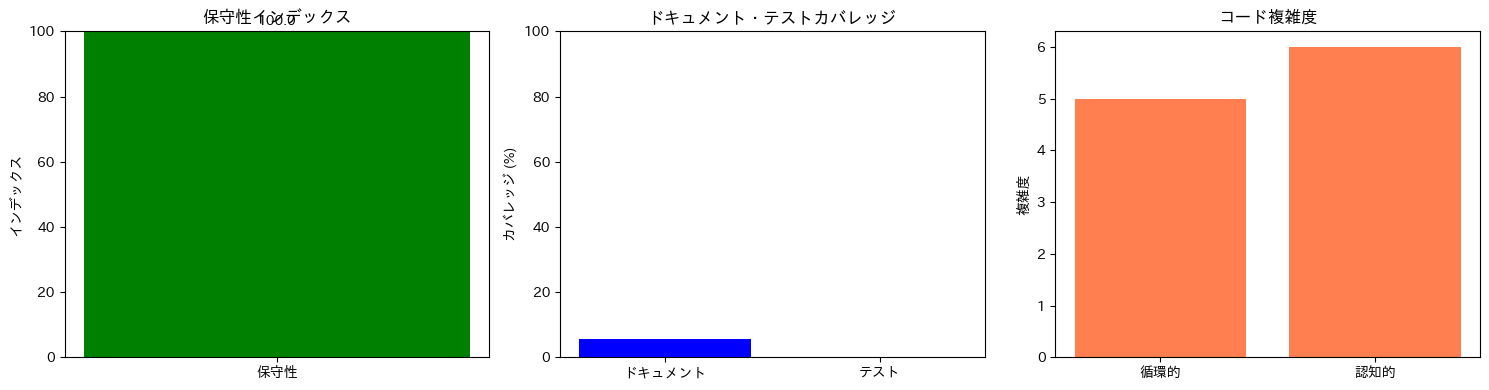


詳細:
- 循環的複雑度: 5
- 認知的複雑度: 6.0
- 保守性インデックス: 100.0/100


In [28]:
# コードメトリクスの可視化
import matplotlib.pyplot as plt
import japanize_matplotlib

def visualize_code_metrics(code: str, language: str = 'python'):
    """コードメトリクスを可視化"""
    
    # メトリクス計算
    metrics = code_analyzer.calculate_metrics(code, language)
    
    # グラフ作成
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. 保守性インデックス
    ax1 = axes[0]
    maintainability = metrics.maintainability_index
    color = 'green' if maintainability > 70 else 'orange' if maintainability > 40 else 'red'
    ax1.bar(['保守性'], [maintainability], color=color)
    ax1.set_ylim(0, 100)
    ax1.set_ylabel('インデックス')
    ax1.set_title('保守性インデックス')
    ax1.text(0, maintainability + 2, f'{maintainability:.1f}', ha='center')
    
    # 2. ドキュメント率とテスト率
    ax2 = axes[1]
    categories = ['ドキュメント', 'テスト']
    values = [metrics.documentation_ratio * 100, metrics.test_ratio * 100]
    colors = ['blue', 'purple']
    ax2.bar(categories, values, color=colors)
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('カバレッジ (%)')
    ax2.set_title('ドキュメント・テストカバレッジ')
    
    # 3. 複雑度
    ax3 = axes[2]
    complexity_data = {
        '循環的': metrics.cyclomatic_complexity,
        '認知的': metrics.cognitive_complexity
    }
    ax3.bar(complexity_data.keys(), complexity_data.values(), color='coral')
    ax3.set_ylabel('複雑度')
    ax3.set_title('コード複雑度')
    
    plt.tight_layout()
    plt.show()
    
    return metrics

# サンプルコードでメトリクス表示
if code_input.value:
    print("📊 コードメトリクス分析")
    metrics = visualize_code_metrics(code_input.value, 'python')
    print(f"\n詳細:")
    print(f"- 循環的複雑度: {metrics.cyclomatic_complexity}")
    print(f"- 認知的複雑度: {metrics.cognitive_complexity:.1f}")
    print(f"- 保守性インデックス: {metrics.maintainability_index:.1f}/100")

In [29]:

# Safe API key handling
import os
api_key = os.getenv('ANTHROPIC_API_KEY')
if not api_key:
    print("⚠️ ANTHROPIC_API_KEY not set. Some features may not work.")
    # Continue with limited functionality

# プロンプト生成エンジンのインポートと初期化
import sys
import os
sys.path.append('.')  # プロジェクトルートをパスに追加

# 既存のsrc/generator.pyとsrc/evaluator.pyをインポート
from src.generator import PromptGenerator
from src.evaluator import PromptEvaluator

# Anthropicクライアント初期化（APIキーが設定されている場合）
generator = None
evaluator = None

if os.getenv('ANTHROPIC_API_KEY') and os.getenv('ANTHROPIC_API_KEY') != 'your_anthropic_api_key_here':
    try:
        # PromptGeneratorのインスタンス作成
        generator = PromptGenerator(model="claude-3-5-sonnet-20241022")
        evaluator = PromptEvaluator(model="claude-3-5-sonnet-20241022")
        print("✅ プロンプト生成エンジン初期化完了")
        print(f"  - Generator: {generator.model}")
        print(f"  - Evaluator: {evaluator.model}")
    except Exception as e:
        print(f"❌ 初期化エラー: {e}")
else:
    print("⚠️ APIキーが設定されていません。.envファイルを確認してください")

✅ プロンプト生成エンジン初期化完了
  - Generator: claude-3-5-sonnet-20241022
  - Evaluator: claude-3-5-sonnet-20241022


In [30]:
# 実際にプロンプトを生成する例
async def generate_prompt_example():
    """プロンプト生成の実例"""
    if not generator:
        print("⚠️ ジェネレーターが初期化されていません")
        return None
    
    # データ分析用プロンプトのリクエスト
    task_type = "data_analysis"
    requirements = "ECサイトの売上データから季節性を分析し、売上向上施策を提案してください"
    context = {
        "data_description": "月別売上データ（過去2年分）",
        "available_data": "商品カテゴリ別売上、顧客属性データ",
        "analysis_objective": "季節性パターンの特定と売上向上"
    }
    constraints = "統計的有意性を検証し、実装可能な具体的施策を提案すること"
    examples = "夏季のアパレル売上増加傾向、年末商戦での家電売上ピーク"
    
    print("🚀 プロンプト生成を開始します...")
    print("\n=== リクエスト内容 ===")
    print(f"タスクタイプ: {task_type}")
    print(f"要求: {requirements}")
    print(f"コンテキスト: {context}")
    print(f"制約: {constraints}")
    
    try:
        # プロンプト生成実行
        result = await generator.generate_prompt(
            task_type=task_type,
            requirements=requirements,
            context=context,
            constraints=constraints,
            examples=examples
        )
        
        print("\n=== 生成結果 ===")
        print(f"✅ プロンプト生成成功")
        print(f"長さ: {len(result)}文字")
        
        print("\n=== 生成されたプロンプト ===")
        print("─" * 50)
        print(result)
        print("─" * 50)
        
        return result
    
    except Exception as e:
        print(f"❌ エラー: {e}")
        import traceback
        traceback.print_exc()
        return None

# 実行例
if generator:
    import asyncio
    generated_prompt = asyncio.run(generate_prompt_example())
else:
    print("ジェネレーターを初期化してから実行してください")

🚀 プロンプト生成を開始します...

=== リクエスト内容 ===
タスクタイプ: data_analysis
要求: ECサイトの売上データから季節性を分析し、売上向上施策を提案してください
コンテキスト: {'data_description': '月別売上データ（過去2年分）', 'available_data': '商品カテゴリ別売上、顧客属性データ', 'analysis_objective': '季節性パターンの特定と売上向上'}
制約: 統計的有意性を検証し、実装可能な具体的施策を提案すること


2025-09-06 13:55:07,441 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"



=== 生成結果 ===
✅ プロンプト生成成功
長さ: 849文字

=== 生成されたプロンプト ===
──────────────────────────────────────────────────
以下のようなプロンプトを提案します：

```
あなたはEコマース分野における上級データアナリストとして、以下のタスクを実行してください。

タスク：
ECサイトの売上データを分析し、以下の3つの要素を含む包括的な分析レポートを作成してください：
1. 季節性パターンの特定と統計的検証
2. カテゴリ別・顧客属性別の相関分析
3. データに基づく具体的な売上向上施策の提案

入力データ：
- 月別売上データ（過去2年分）
- 商品カテゴリ別売上データ
- 顧客属性データ

期待する出力形式：
1. 季節性分析
   - 月別売上トレンド
   - 統計的有意性の検定結果
   - 特定された主要な季節パターン

2. クロス分析
   - カテゴリ×季節のヒートマップ
   - 顧客属性×購買パターンの相関

3. 施策提案
   - 短期施策（即実施可能）
   - 中期施策（3-6ヶ月以内）
   - 長期施策（6ヶ月以上）

制約条件：
- すべての分析結果に統計的有意性の検証を含めること
- 提案する施策は具体的な実施手順を含むこと
- ROIの試算を含めること
- 季節変動要因と非季節変動要因を明確に区別すること

分析の注意点：
- 異常値や外れ値の処理方法を明記すること
- 時系列データの周期性を考慮すること
- 商品カテゴリ間の相互作用も考慮すること

施策提案の例示フォーマット：
施策名：[具体的な名称]
目的：[期待される効果]
実施時期：[最適な実施タイミング]
必要リソース：[人的・金銭的リソース]
期待ROI：[数値で表現]
実施手順：[具体的なステップ]
```

このプロンプトは：
1. 明確な役割（上級データアナリスト）を定義
2. 具体的な分析ステップを提示
3. 期待する出力形式を詳細に指定
4. 制約条件を明確に設定
5. 施策提案の具体的なフォーマットを例示

しており、質の高い分析結果を得るための構造化された指示となっています。
───────────────────────────────────────────

In [31]:
# プロンプト品質評価の実例
def evaluate_prompt_example(prompt_content=None):
    """プロンプトの品質を評価する例"""
    if not evaluator:
        print("⚠️ エバリュエーターが初期化されていません")
        return None
    
    # 評価対象のプロンプト（サンプルまたは前のセルで生成したもの）
    if prompt_content is None:
        prompt_content = """
あなたはデータ分析の専門家です。

【分析対象】
ECサイトの月別売上データ（過去2年分）、商品カテゴリ別売上、顧客属性データ

【分析目的】
季節性パターンの特定と売上向上施策の提案

【分析手法】
時系列分析、季節性分解、相関分析

【出力要件】
1. 季節性パターンの可視化と解釈
2. 統計的に有意な傾向の特定
3. 具体的な売上向上施策（最低3つ）
4. 各施策のROI予測
5. 実装優先度の提案

【制約条件】
- 統計的有意性（p値<0.05）を確保すること
- ビジネス実装可能な施策のみ提案すること
- 予算制約を考慮すること
        """.strip()
    
    print("🎯 プロンプト品質評価を開始します...")
    print(f"評価対象プロンプトの長さ: {len(prompt_content)}文字")
    
    try:
        # 品質評価実行
        scores = evaluator.evaluate(prompt_content)
        
        print("\n=== 評価結果 ===")
        print("📊 品質スコア:")
        for metric, score in scores.items():
            if metric != 'overall':
                status = "✅" if score >= 0.7 else "⚠️" if score >= 0.5 else "❌"
                print(f"  {status} {metric}: {score:.2f}/1.0")
        
        print(f"\n🎯 総合スコア: {scores.get('overall', 0):.2f}/1.0")
        
        # 改善提案を取得
        suggestions = evaluator.get_improvement_suggestions(prompt_content, scores)
        if suggestions:
            print("\n💡 改善提案:")
            for i, suggestion in enumerate(suggestions, 1):
                print(f"  {i}. {suggestion}")
        
        return scores
    
    except Exception as e:
        print(f"❌ エラー: {e}")
        import traceback
        traceback.print_exc()
        return None

# 実行例
if evaluator:
    evaluation_result = evaluate_prompt_example()
else:
    print("エバリュエーターを初期化してから実行してください")

🎯 プロンプト品質評価を開始します...
評価対象プロンプトの長さ: 273文字

=== 評価結果 ===
📊 品質スコア:
  ✅ clarity: 1.00/1.0
  ✅ specificity: 0.80/1.0
  ✅ completeness: 0.90/1.0
  ✅ efficiency: 0.80/1.0
  ⚠️ reproducibility: 0.50/1.0

🎯 総合スコア: 0.82/1.0

💡 改善提案:
  1. 出力形式の明確な指定と具体例を追加してください


In [32]:
# プロンプト改善の実例
async def improve_prompt_example():
    """プロンプトを改善する例"""
    if not generator or not evaluator:
        print("⚠️ ジェネレーターまたはエバリュエーターが初期化されていません")
        return None
    
    print("🔄 プロンプト改善プロセスを開始します...")
    
    # Step 1: 初期プロンプト生成
    print("\n📝 Step 1: 初期プロンプト生成")
    
    initial_prompt = await generator.generate_prompt(
        task_type="text_processing",
        requirements="顧客レビューを分析して感情分析と要約を行いたい",
        context={"data": "製品レビューデータ（1000件）"},
        constraints="処理時間は5分以内"
    )
    
    if not initial_prompt:
        print("❌ 初期プロンプト生成に失敗しました")
        return None
        
    print(f"初期プロンプト生成完了: {len(initial_prompt)}文字")
    
    # Step 2: 品質評価
    print("\n📊 Step 2: 初期プロンプトの品質評価")
    initial_scores = evaluator.evaluate(initial_prompt)
    
    print(f"初期スコア: {initial_scores.get('overall', 0):.2f}/1.0")
    
    # Step 3: プロンプト改善
    print("\n🚀 Step 3: フィードバックに基づく改善")
    
    # 改善提案を取得
    suggestions = evaluator.get_improvement_suggestions(initial_prompt, initial_scores)
    feedback = "以下の点を改善してください: " + ", ".join(suggestions) if suggestions else "より具体的で明確な指示を追加してください"
    
    # 改善実行
    improved_prompt = generator.improve_prompt(initial_prompt, feedback)
    
    print(f"改善プロンプト生成完了: {len(improved_prompt)}文字")
    
    # Step 4: 改善後の評価
    print("\n📊 Step 4: 改善後プロンプトの品質評価")
    final_scores = evaluator.evaluate(improved_prompt)
    
    print(f"改善後スコア: {final_scores.get('overall', 0):.2f}/1.0")
    
    # 結果比較
    print("\n=== 改善結果サマリー ===")
    initial_overall = initial_scores.get('overall', 0)
    final_overall = final_scores.get('overall', 0)
    improvement = final_overall - initial_overall
    
    print(f"初期スコア: {initial_overall:.2f}/1.0")
    print(f"最終スコア: {final_overall:.2f}/1.0")
    print(f"改善度: {improvement:+.2f}ポイント")
    
    if improvement > 0:
        print("✅ プロンプトの品質が向上しました！")
    elif improvement == 0:
        print("➖ スコアに変化はありませんでした")
    else:
        print("⚠️ スコアが低下しました（再改善が必要かもしれません）")
    
    # 各メトリクスの変化を表示
    print("\n📈 メトリクス別の変化:")
    for metric in ['clarity', 'specificity', 'completeness', 'efficiency', 'reproducibility']:
        initial_val = initial_scores.get(metric, 0)
        final_val = final_scores.get(metric, 0)
        change = final_val - initial_val
        status = "📈" if change > 0 else "📉" if change < 0 else "➖"
        print(f"  {status} {metric}: {initial_val:.2f} → {final_val:.2f} ({change:+.2f})")
    
    return {
        'initial_prompt': initial_prompt,
        'improved_prompt': improved_prompt,
        'initial_scores': initial_scores,
        'final_scores': final_scores
    }

# 実行例
if generator and evaluator:
    import asyncio
    improvement_result = asyncio.run(improve_prompt_example())
else:
    print("ジェネレーターとエバリュエーターを初期化してから実行してください")

🔄 プロンプト改善プロセスを開始します...

📝 Step 1: 初期プロンプト生成


2025-09-06 13:55:18,226 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


初期プロンプト生成完了: 1028文字

📊 Step 2: 初期プロンプトの品質評価
初期スコア: 0.92/1.0

🚀 Step 3: フィードバックに基づく改善


2025-09-06 13:55:38,194 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


改善プロンプト生成完了: 2347文字

📊 Step 4: 改善後プロンプトの品質評価
改善後スコア: 0.87/1.0

=== 改善結果サマリー ===
初期スコア: 0.92/1.0
最終スコア: 0.87/1.0
改善度: -0.05ポイント
⚠️ スコアが低下しました（再改善が必要かもしれません）

📈 メトリクス別の変化:
  ➖ clarity: 0.90 → 0.90 (+0.00)
  ➖ specificity: 1.00 → 1.00 (+0.00)
  ➖ completeness: 1.00 → 1.00 (+0.00)
  📉 efficiency: 0.80 → 0.50 (-0.30)
  ➖ reproducibility: 0.80 → 0.80 (+0.00)


In [ ]:
# 各プロンプトタイプのサンプル生成
async def generate_all_types_example():
    """全てのプロンプトタイプのサンプルを生成"""
    if not generator:
        print("⚠️ ジェネレーターが初期化されていません")
        return None
    
    print("🎯 全プロンプトタイプのサンプル生成を開始...")
    
    # 各タイプの設定
    prompt_configs = [
        {
            'type': 'data_analysis',
            'name': 'データ分析',
            'requirements': '売上データの時系列分析を行いたい',
            'context': {'data': '月次売上データ（3年分）'}
        },
        {
            'type': 'image_recognition',
            'name': '画像認識',
            'requirements': '製品画像から不良品を検出したい',
            'context': {'data': '工場の品質検査画像データ'}
        },
        {
            'type': 'text_processing',
            'name': 'テキスト処理',
            'requirements': 'SNSの投稿から感情分析を行いたい',
            'context': {'data': 'Twitter/Xの投稿データ'}
        },
        {
            'type': 'requirements_analysis',
            'name': '要件分析',
            'requirements': '新規Webアプリの要件定義を行いたい',
            'context': {'project': 'BtoB SaaSプロダクト'}
        },
        {
            'type': 'api_testing',
            'name': 'APIテスト',
            'requirements': 'REST APIのテストケースを作成したい',
            'context': {'api': 'ユーザー管理API'}
        },
        {
            'type': 'general_poc',
            'name': '汎用PoC',
            'requirements': 'AIチャットボットのPoCを作成したい',
            'context': {'purpose': 'カスタマーサポート向け'}
        }
    ]
    
    results = {}
    
    for config in prompt_configs:
        print(f"\n📝 {config['name']}プロンプト生成中...")
        
        try:
            result = await generator.generate_prompt(
                task_type=config['type'],
                requirements=config['requirements'],
                context=config['context']
            )
            
            results[config['type']] = {
                'name': config['name'],
                'prompt': result,
                'length': len(result)
            }
            print(f"  ✅ 完了: {len(result)}文字")
        except Exception as e:
            print(f"  ❌ エラー: {e}")
            results[config['type']] = None
    
    # 結果表示
    print("\n=== 生成結果サマリー ===")
    success_count = 0
    for type_key, result in results.items():
        if result:
            print(f"✅ {result['name']}: {result['length']}文字")
            success_count += 1
        else:
            print(f"❌ {type_key}: 生成失敗")
    
    print(f"\n成功率: {success_count}/{len(prompt_configs)} ({success_count/len(prompt_configs)*100:.0f}%)")
    
    # 最初の成功したプロンプトの一部を表示
    for type_key, result in results.items():
        if result:
            print("\n=== サンプル表示（" + result['name'] + "） ===")
            print(result['prompt'][:500] + "..." if len(result['prompt']) > 500 else result['prompt'])
            break
    
    return results

# 実行例
if generator:
    import asyncio
    all_prompts = asyncio.run(generate_all_types_example())
else:
    print("ジェネレーターを初期化してから実行してください")

🎯 全プロンプトタイプのサンプル生成を開始...

📝 データ分析プロンプト生成中...
